# Score: 

Huge thank you to [Minsuk Heo](https://github.com/minsuk-heo) ([his work](https://github.com/minsuk-heo/kaggle-titanic/blob/master/titanic-solution.ipynb)) and [Yassine Ghouzam](https://www.kaggle.com/yassineghouzam) ([his work](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling))!

A lot of this work was inspired by them

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

### Data

In [2]:
train = pd.read_csv('/Users/pbezuhov/git/Kaggle/data/titanic/train.csv')
test  = pd.read_csv('/Users/pbezuhov/git/Kaggle/data/titanic/test.csv')

### Remove outliers

In [3]:
from collections import Counter

# Outlier detection curtesy of Yassine who in turn was motivated by the Tukey method
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)  # 3rd quartile (75%)
        IQR = Q3 - Q1                   # Interquartile range (IQR)
    
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
outliers_to_drop = detect_outliers(train, 2, ["Age","SibSp","Parch","Fare"])

train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


### Concat train and test data for easier manipulation

In [4]:
full  = pd.concat([train, test], axis=0).reset_index(drop=True)

train_N = len(train)
del train, test

full = full.fillna(np.nan)

### Creating a Title Column

In [5]:
# Pulling the title information out of people's name (like mr, mrs, dr, etc)
full['Title'] = full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 1, "Mlle": 1, "Mme": 1, "Ms": 3,
                 "Master": 2, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3 ,"Countess": 3,
                 "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3,"Capt": 3,"Sir": 3 }

full['Title'] = full['Title'].map(title_mapping)
    
# delete unnecessary feature from dataset
full.drop('Name', axis=1, inplace=True)

### Fill NaN values

In [6]:
#### Age
index_NaN_age = list(full["Age"][full["Age"].isnull()].index)
for i in index_NaN_age :
    age_med = full["Age"].median()
    age_pred = full["Age"][
                            ((full['SibSp'] == full.iloc[i]["SibSp"]) &
                             (full['Parch'] == full.iloc[i]["Parch"]) &
                             (full['Pclass'] == full.iloc[i]["Pclass"]))
                          ].median()
    if not np.isnan(age_pred) :
        full['Age'].iloc[i] = age_pred
    else :
        full['Age'].iloc[i] = age_med

#### Embarked
# The most embarked station is S, so it's safe to fill in nan values with S
full['Embarked'] = full['Embarked'].fillna('S')

#### Fare
# fill missing Fare with median fare for each Pclass
full["Fare"].fillna(full.groupby("Pclass")["Fare"].transform("median"), inplace=True)

#### Cabin
full['Cabin'] = full['Cabin'].str[:1]
full["Cabin"].fillna("None", inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Create a family size column

Thanks again to Minsuk and Yassine!

In [7]:
# Create a family size descriptor from SibSp and Parch
full["Fsize"] = full["SibSp"] + full["Parch"] + 1

# Create new feature of family size
full['Single'] = full['Fsize'].map(lambda s: 1 if s == 1 else 0)
full['SmallF'] = full['Fsize'].map(lambda s: 1 if  s == 2  else 0)
full['MedF']   = full['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
full['LargeF'] = full['Fsize'].map(lambda s: 1 if s >= 5 else 0)

### Reduce Skew

In [8]:
# Apply log to Fare to reduce skewness distribution
full["Fare"] = full["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

### Ticket Column

In [9]:
# Just remove it
full.drop(labels=["Ticket"], axis=1, inplace=True)
full.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,None,S,1.981001,0,1,3,male,1,0.0,0,2,0,1,0,0
1,38.0,C,C,4.266662,0,2,1,female,1,1.0,1,2,0,1,0,0
2,26.0,None,S,2.070022,0,3,3,female,0,1.0,1,1,1,0,0,0
3,35.0,C,S,3.972177,0,4,1,female,1,1.0,1,2,0,1,0,0
4,35.0,None,S,2.085672,0,5,3,male,0,0.0,0,1,1,0,0,0


### Bin Age and Fare columns

In [10]:
### Age
full.loc[ full['Age'] <= 16, 'Age'] = 0,
full.loc[(full['Age'] > 16) & (full['Age'] <= 26), 'Age'] = 1,
full.loc[(full['Age'] > 26) & (full['Age'] <= 36), 'Age'] = 2,
full.loc[(full['Age'] > 36) & (full['Age'] <= 62), 'Age'] = 3,
full.loc[ full['Age'] > 62, 'Age'] = 4

### Fare
full.loc[ full['Fare'] <= 17, 'Fare'] = 0,
full.loc[(full['Fare'] > 17) & (full['Fare'] <= 30), 'Fare'] = 1,
full.loc[(full['Fare'] > 30) & (full['Fare'] <= 100), 'Fare'] = 2,
full.loc[ full['Fare'] > 100, 'Fare'] = 3

### Convert to categorical variables to numeric

In [11]:
# convert to indicator values Title and Embarked 
full.Sex      = full.Sex.map(      { "male": 0, "female": 1}   )
full.Pclass   = full.Pclass.map(   { 1: 0, 2: 0.5, 3: 1}       )
full.Embarked = full.Embarked.map( { "S": 0, "C": 0.5, "Q": 1} )
full.Cabin    = full.Cabin.map(    { "None": 0, "C": 0.2, "B": 0.4,
                                     "D": 0.6, "E": 0.8, "A": 1,
                                     "F": 1, "G": 1, "T": 1} )

### Split the data back into train and test data

In [12]:
train = full[:train_N]
test = full[train_N:]
test.drop(labels=["Survived"], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Split the training data into target and predictors

In [13]:
train["Survived"] = train["Survived"].astype(int)
train_y = train["Survived"]
train_x = train.drop(labels=["Survived", "PassengerId"], axis=1)
test_x  = test.drop("PassengerId", axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Modeling

In [14]:
# Massive amounts of model imports
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# META MODELING

### Adaboost

In [15]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(train_x, train_y)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 920 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    3.6s finished


0.79795686719636771

### ExtraTrees 

In [18]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(train_x, train_y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


0.82633371169125991

### Random Forest Classifier

In [19]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(train_x, train_y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


0.83087400681044266

### Gradient Boost Classifier

In [17]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train_x, train_y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   35.7s finished


0.83427922814982969

### SVC Classifier

In [16]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train_x, train_y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   24.9s finished


0.82860385925085134

### Averaging all the models

In [17]:
test_Survived_RFC  = pd.Series(RFC_best.predict( test_x), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_x), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_x), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict( test_x), name="Ada")
test_Survived_GBC  = pd.Series(GBC_best.predict( test_x), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([
                                test_Survived_RFC,
                                test_Survived_ExtC,
                                test_Survived_AdaC,
                                test_Survived_GBC,
                                test_Survived_SVMC
                             ],axis=1)

votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(train_x, train_y)

NameError: name 'RFC_best' is not defined

### Predicting and saving results

In [18]:
predictions = SVMC_best.predict(test_x) #votingC.predict(test_x)

predictions = pd.DataFrame({
                            "PassengerId": test.PassengerId,
                            "Survived": predictions
                            })

predictions.to_csv("../../submissions/titanic.csv",index=False)

# Extra

Taken from Yassine's code.  I think these plots are very interesting

### Plot learning curves

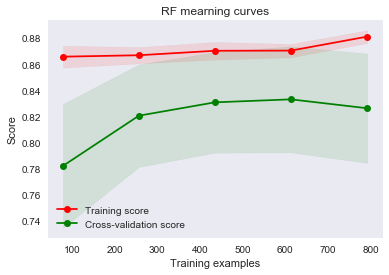

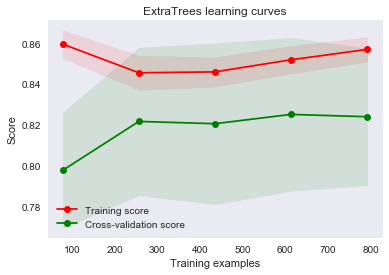

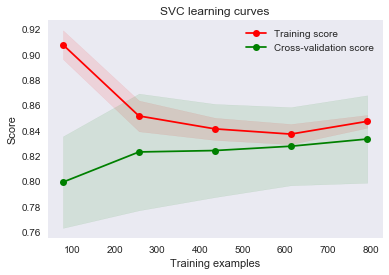

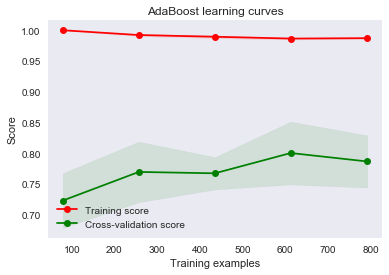

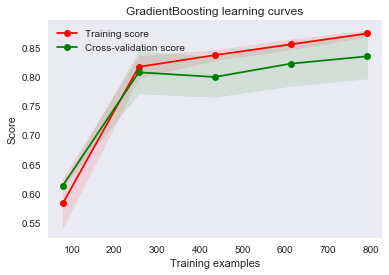

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve( gsRFC.best_estimator_,   "RF mearning curves",               train_x, train_y, cv=kfold )
g = plot_learning_curve( gsExtC.best_estimator_,  "ExtraTrees learning curves",       train_x, train_y, cv=kfold )
g = plot_learning_curve( gsSVMC.best_estimator_,  "SVC learning curves",              train_x, train_y, cv=kfold )
g = plot_learning_curve( gsadaDTC.best_estimator_,"AdaBoost learning curves",         train_x, train_y, cv=kfold )
g = plot_learning_curve( gsGBC.best_estimator_,   "GradientBoosting learning curves", train_x, train_y, cv=kfold )